# Adaptive Tracking Simulation Example

## Setup

In [149]:
from datetime import datetime, timedelta
start_time = datetime.now()

In [150]:
from stonesoup.models.transition.linear import CombinedLinearGaussianTransitionModel, ConstantVelocity, SingerApproximate
import numpy as np

transition_model = CombinedLinearGaussianTransitionModel([
    # ConstantVelocity(10),
    # ConstantVelocity(10),
    SingerApproximate(10, 1),
    SingerApproximate(10, 1),
    ConstantVelocity(0),
])

## Radar system

In [151]:
from mpar_sim.radar import PhasedArrayRadar
from mpar_sim.beam.beam import RectangularBeam, GaussianBeam
from mpar_sim.looks.look import Look
from mpar_sim.resource_management import PAPResourceManager
from mpar_sim.schedulers import BestFirstScheduler
import numpy as np

radar = PhasedArrayRadar(
    ndim_state=transition_model.ndim_state,
    position_mapping=(0, 3, 6),
    velocity_mapping=(1, 4, 7),
    position=np.array([[0], [0], [0]]),
    rotation_offset=np.array([[0], [0], [0]]),
    # Array parameters
    n_elements_x=32,
    n_elements_y=32,
    element_spacing=0.5,  # Wavelengths
    element_tx_power=10,
    # System parameters
    center_frequency=3e9,
    system_temperature=290,
    noise_figure=4,
    # Scan settings
    beam_shape=RectangularBeam,
    az_fov=[-45, 45],
    el_fov=[-45, 45],
    # Detection settings
    false_alarm_rate=1e-6,
    include_false_alarms=False
)
radar.timestamp = start_time

manager = PAPResourceManager(radar,
                             max_duty_cycle=0.1,
                             max_bandwidth=100e6)
scheduler = BestFirstScheduler(manager,
                               sort_key="start_time",
                               reverse_sort=False,
                               max_time_delta=timedelta(seconds=2))


Raster scan agent

In [152]:
from mpar_sim.agents.raster_scan import RasterScanAgent
import numpy as np

search_agent = RasterScanAgent(
    azimuth_scan_limits=np.array([-30, 30]),
    elevation_scan_limits=np.array([-5, 5]),
    azimuth_beam_spacing=0.75,
    elevation_beam_spacing=0.75,
    azimuth_beamwidth=10,
    elevation_beamwidth=10,
    bandwidth=100e6,
    pulsewidth=1e-6,
    prf=5e3,
    n_pulses=100,
)

## Tracker Components

Create tracker

In [153]:
from stonesoup.measures import Mahalanobis, Euclidean
from stonesoup.hypothesiser.distance import DistanceHypothesiser
from stonesoup.updater.kalman import ExtendedKalmanUpdater
from stonesoup.predictor.kalman import KalmanPredictor
from stonesoup.gater.distance import DistanceGater

predictor = KalmanPredictor(transition_model)

updater = ExtendedKalmanUpdater(measurement_model=None)

hypothesizer = DistanceHypothesiser(
    predictor, updater, measure=Mahalanobis(), missed_distance=50)

Create the data associator

In [154]:
from stonesoup.dataassociator.neighbour import GNNWith2DAssignment
associator = GNNWith2DAssignment(hypothesizer)

Create the deleter

In [155]:
from stonesoup.deleter.time import UpdateTimeStepsDeleter
from stonesoup.deleter.multi import CompositeDeleter
from mpar_sim.deleter.error import AngularErrorDeleter

track_beamwidth = 3
error_deleter = AngularErrorDeleter(error_thresh=0.35*np.deg2rad(track_beamwidth),
                                    position_mapping=radar.position_mapping)
time_deleter = UpdateTimeStepsDeleter(5)
deleter = CompositeDeleter(
    [error_deleter, time_deleter], delete_last_pred=True, intersect=True)


Create the initiator

In [156]:
from stonesoup.types.state import GaussianState
from stonesoup.initiator.simple import MultiMeasurementInitiator, SimpleMeasurementInitiator
import numpy as np
from mpar_sim.initiator.initators import MofNInitiator

prior_mean = np.zeros((radar.ndim_state,))
prior_cov = np.diag(np.zeros((radar.ndim_state,)))
initiator = MofNInitiator(
    prior_state=GaussianState(prior_mean, prior_cov),
    measurement_model=None,
    deleter=time_deleter,
    associator=associator,
    updater=updater,
    confirmation_threshold=[3,5],
)

Tracking agent

In [157]:
from mpar_sim.agents.track_while_scan import TWSAgent
from mpar_sim.agents.adaptive_track import AdaptiveTrackAgent
from mpar_sim.beam.common import aperture2beamwidth

track_agent = AdaptiveTrackAgent(
    initiator,
    associator,
    predictor,
    updater,
    deleter,
    # Adaptive track parameters
    track_sharpness=0.20,
    min_revisit_rate=0.1,
    max_revisit_rate=10,
    confirm_rate=20,
    # Task parameters
    azimuth_beamwidth=3,
    elevation_beamwidth=3,
    bandwidth=100e6,
    pulsewidth=10e-6,
    prf=5e3,
    n_pulses=100
)

# track_agent = TWSAgent(initiator, associator, updater, deleter)


## Run the simulation

In [158]:
from typing import Set, List
from stonesoup.types.groundtruth import GroundTruthPath, GroundTruthState
import datetime


def move(truths: List[GroundTruthPath], 
         reference_time: datetime.datetime, 
         current_time: datetime.datetime):
  """
  Interpolate each target in the list to the current time without noise. This is used to propagate the target position between waypoints/global simulation updates.
  """
  current_truths = []
  dt = current_time - reference_time
  for truth in truths:
    if radar.is_detectable(truth[-1]):
      state = GroundTruthState(
          transition_model.function(truth[-1],
                                    noise=False,
                                    time_interval=dt),
          timestamp=reference_time)
      truth.append(GroundTruthPath([state]))
      current_truths.append(truth)

  return current_truths


In [159]:
import copy
import operator
from stonesoup.types.groundtruth import GroundTruthPath, GroundTruthState
from stonesoup.types.array import CovarianceMatrix
from stonesoup.types.state import StateVector
import random
from stonesoup.simulator.simple import MultiTargetGroundTruthSimulator
from mpar_sim.simulator.simple import MultiTargetScenario
from mpar_sim.looks.volume_search import VolumeSearchLook

# Set the simulation seed
seed = np.random.randint(0, 2**32-1)

# Simulation-level parameters
include_noise = True

# Target generation parameters
if radar.ndim_state == 6:
  initial_state_mean = StateVector([1000, 10, 0, 0, 0, 0])
  initial_state_covariance = CovarianceMatrix(
      np.diag([200, 50, 200, 10, 0, 0]))
elif radar.ndim_state == 8:
  initial_state_mean = StateVector([2000, 10, 0, 0, 0, 0, 0, 0])
  initial_state_covariance = CovarianceMatrix(
      np.diag([500, 50, 10, 200, 50, 5, 0, 0]))
initial_state = GaussianState(
    initial_state_mean, initial_state_covariance, timestamp=start_time)
target_rcs = 10

scenario = MultiTargetScenario(
    transition_model=transition_model,
    initial_state=initial_state,
    timestep=timedelta(seconds=0),
    number_steps=1000,
    birth_rate=0,
    death_probability=0,
    seed=seed,
    initial_number_targets=10,
)


# Simulation state information
truths = []
all_truths = set()
confirmed_tracks = set()
tentative_tracks = set()
all_measurements = []
all_tracks = set()

# Metrics
n_truths = []
n_tentative_tracks = []
n_confirmed_tracks = []
position_accuracy = []
velocity_accuracy = []
times = []

# Simulation time variables.
time = start_time
scheduler_time = start_time
for time, truths in scenario:

  ########################################
  # Simulate the current look
  ########################################
  if manager.allocated_tasks:
    look = manager.allocated_tasks.pop()
    scheduler_time = look.end_time
    radar.load_look(look)
    if look.start_time > time:
      # Interpolate targets to the start of the look
      current_truths = move(truths, time, look.start_time)
    else:
      current_truths = truths
    # Also add the current RCS to the target truth
    for truth in current_truths:
      truth.states[-1].rcs = target_rcs

    detections = radar.measure(current_truths, noise=include_noise)

    # Update tracks
    if len(detections) > 0 or not isinstance(look, VolumeSearchLook) or isinstance(track_agent, TWSAgent):
      confirmed_tracks = track_agent.update_tracks(detections, look.start_time)

    # Update scenario information
    all_truths |= truths
    all_tracks |= confirmed_tracks
    all_measurements.append(detections)

    # Update metrics
    times.append(look.start_time)
    n_truths.append(len(current_truths))
    n_tentative_tracks.append(len(track_agent.initiator.holding_tracks))
    n_confirmed_tracks.append(len(confirmed_tracks))

  ########################################
  # Allocate resources
  ########################################
  # Generate looks from each agent
  search_looks = search_agent.act(current_time=scheduler_time, n_looks=1)
  track_looks = track_agent.act(current_time=scheduler_time)

  looks = search_looks + track_looks

  # Schedule new looks, sorted so that the task with the nearest end time is selected first below
  scheduler.schedule(looks, scheduler_time)
  manager.allocated_tasks.sort(
      key=operator.attrgetter("end_time"), reverse=True)

  ########################################
  # Update scenario
  ########################################
  # Minimum start time of all scheduled tasks. When this changes, a new "batch" of tasks has been allocated and the scenario needs to be updated
  min_start_time = min([task.start_time for task in manager.allocated_tasks]
                       ) if manager.allocated_tasks else time

  scenario.timestep = min_start_time - time


## Plot simulation results

In [160]:
from stonesoup.plotter import Plotterly

plotter = Plotterly()
plotter.plot_sensors(radar, "Radar")
plotter.plot_ground_truths(all_truths, radar.position_mapping[:2])
plotter.plot_measurements(all_measurements, radar.position_mapping[:2])
plotter.plot_tracks(all_tracks, radar.position_mapping[:2])
plotter.fig


[]

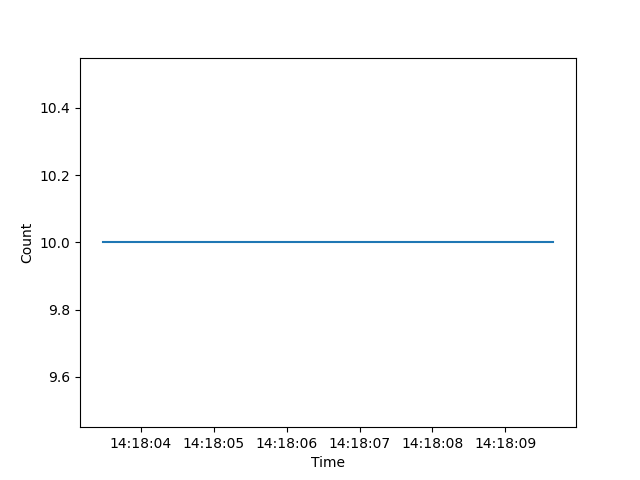

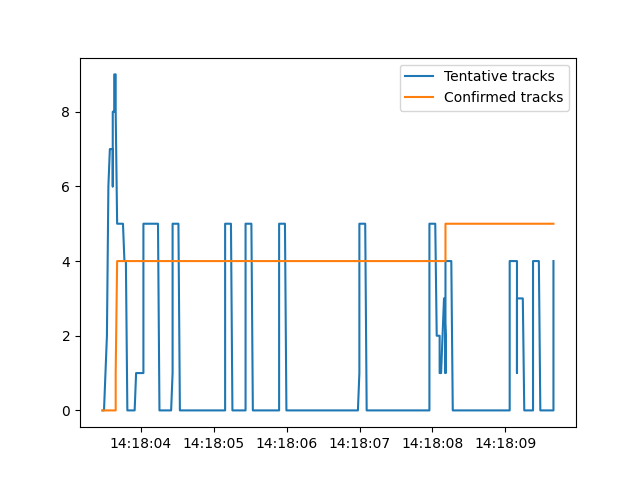

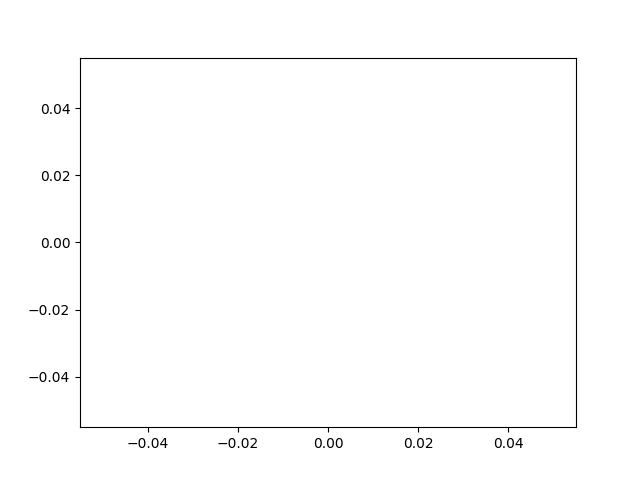

In [161]:
%matplotlib widget
import matplotlib.pyplot as plt

# Plot detections
fig = plt.figure()
plt.plot(times, n_truths, label='Truths')
plt.xlabel('Time')
plt.ylabel('Count')

# Plot tracks
fig = plt.figure()
plt.plot(times, n_tentative_tracks, label='Tentative tracks')
plt.plot(times, n_confirmed_tracks, label='Confirmed tracks')
plt.legend()

# Plot errors
fig = plt.figure()
plt.plot()

